# Data Preprocessing for BERT Sentiment Analysis

This notebook processes the Twitter sentiment data by:
- Removing duplicated tweets
- Removing/anonymizing mentions (@user)
- Cleaning text for better BERT training
- Combining multiple training files into a single dataset

In [1]:
import pandas as pd
import numpy as np
import re
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
# Set up paths
dataset_path = Path('../dataset')
train_path = dataset_path / 'train'
test_path = dataset_path / 'test'
output_path = dataset_path / 'processed'
output_path.mkdir(exist_ok=True)

## Load and Explore Data

In [3]:
def load_twitter_data(file_path):
    """Load Twitter data from tab-separated file."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                tweet_id, sentiment, text = parts[0], parts[1], '\t'.join(parts[2:])
                data.append({'tweet_id': tweet_id, 'sentiment': sentiment, 'text': text})
    return pd.DataFrame(data)

# Load all training files
train_files = list(train_path.glob('*.txt'))
print(f"Found {len(train_files)} training files:")
for f in train_files:
    print(f"  - {f.name}")

# Load and combine all training data
all_data = []
for file_path in train_files:
    df = load_twitter_data(file_path)
    df['source_file'] = file_path.name
    all_data.append(df)
    print(f"{file_path.name}: {len(df)} tweets")

# Combine all data
combined_df = pd.concat(all_data, ignore_index=True)
print(f"\nTotal tweets: {len(combined_df)}")

Found 11 training files:
  - twitter-2013test-A.txt
  - twitter-2014test-A.txt
  - twitter-2014sarcasm-A.txt
  - twitter-2016devtest-A.txt
  - twitter-2016train-A.txt
  - twitter-2016dev-A.txt
  - twitter-2013dev-A.txt
  - twitter-2015test-A.txt
  - twitter-2015train-A.txt
  - twitter-2016test-A.txt
  - twitter-2013train-A.txt
twitter-2013test-A.txt: 3547 tweets
twitter-2014test-A.txt: 1853 tweets
twitter-2014sarcasm-A.txt: 86 tweets
twitter-2016devtest-A.txt: 2000 tweets
twitter-2016train-A.txt: 6000 tweets
twitter-2016dev-A.txt: 1999 tweets
twitter-2013dev-A.txt: 1654 tweets
twitter-2015test-A.txt: 2390 tweets
twitter-2015train-A.txt: 489 tweets
twitter-2016test-A.txt: 20632 tweets
twitter-2013train-A.txt: 9684 tweets

Total tweets: 50334


In [4]:
# Display basic statistics
print("Sentiment distribution:")
print(combined_df['sentiment'].value_counts())
print(f"\nUnique tweet IDs: {combined_df['tweet_id'].nunique()}")
print(f"Total tweets: {len(combined_df)}")
print(f"Duplicates based on tweet_id: {len(combined_df) - combined_df['tweet_id'].nunique()}")

Sentiment distribution:
sentiment
neutral     22591
positive    19903
negative     7840
Name: count, dtype: int64

Unique tweet IDs: 49570
Total tweets: 50334
Duplicates based on tweet_id: 764


In [5]:
# Show some sample data
print("Sample tweets:")
combined_df.head(10)

Sample tweets:


,tweet_id,sentiment,text,source_file
0,264238274963451904,positive,"""@jjuueellzz down in the Atlantic city, ventno...",twitter-2013test-A.txt
1,218775148495515649,positive,"""Musical awareness: Great Big Beautiful Tomorr...",twitter-2013test-A.txt
2,258965201766998017,neutral,On Radio786 100.4fm 7:10 Fri Oct 19 Labour ana...,twitter-2013test-A.txt
3,262926411352903682,negative,"""Kapan sih lo ngebuktiin,jan ngomong doang Sus...",twitter-2013test-A.txt
4,171874368908050432,neutral,"""Excuse the connectivity of this live stream, ...",twitter-2013test-A.txt
5,256010056942903296,positive,Show your LOVE for your local field & it might...,twitter-2013test-A.txt
6,253809989599232000,neutral,"""Milton on Bolton Wanderers 2 v 2 Leeds United...",twitter-2013test-A.txt
7,261776619146985472,positive,@firecore Can you tell me when an update for t...,twitter-2013test-A.txt
8,264143999374356481,positive,"""@Heavensbasement The Crown, Filthy McNastys, ...",twitter-2013test-A.txt
9,223052929131757571,neutral,"""Uncover the Eternal City! Return flights to R...",twitter-2013test-A.txt


## Data Cleaning Functions

In [6]:
def remove_mentions(text):
    """Remove @mentions from text."""
    return re.sub(r'@\w+', '@user', text)

def clean_text(text):
    """Clean text for BERT training."""
    # Remove mentions
    text = remove_mentions(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove tweets that are too short after cleaning
    if len(text.strip()) < 3:
        return None
    
    return text

def remove_duplicates(df):
    """Remove duplicate tweets based on tweet_id and text content."""
    print(f"Before duplicate removal: {len(df)} tweets")
    
    # Remove duplicates based on tweet_id
    df_no_id_dups = df.drop_duplicates(subset=['tweet_id'], keep='first')
    print(f"After removing tweet_id duplicates: {len(df_no_id_dups)} tweets")
    
    # Remove duplicates based on text content (after cleaning)
    df_no_id_dups['cleaned_text'] = df_no_id_dups['text'].apply(clean_text)
    
    # Remove rows where text became None/empty after cleaning
    df_cleaned = df_no_id_dups.dropna(subset=['cleaned_text'])
    df_cleaned = df_cleaned[df_cleaned['cleaned_text'].str.len() > 0]
    print(f"After removing empty texts: {len(df_cleaned)} tweets")
    
    # Remove text content duplicates
    df_final = df_cleaned.drop_duplicates(subset=['cleaned_text'], keep='first')
    print(f"After removing text duplicates: {len(df_final)} tweets")
    
    return df_final

## Apply Data Cleaning

In [7]:
# Remove duplicates and clean text
cleaned_df = remove_duplicates(combined_df)

# Update the text column with cleaned text
cleaned_df['text'] = cleaned_df['cleaned_text']
cleaned_df = cleaned_df.drop('cleaned_text', axis=1)

print("\nFinal dataset statistics:")
print(f"Total tweets: {len(cleaned_df)}")
print("\nSentiment distribution:")
print(cleaned_df['sentiment'].value_counts())
print("\nPercentage distribution:")
print(cleaned_df['sentiment'].value_counts(normalize=True) * 100)

Before duplicate removal: 50334 tweets
After removing tweet_id duplicates: 49570 tweets
After removing empty texts: 49569 tweets
After removing text duplicates: 49526 tweets

Final dataset statistics:
Total tweets: 49526

Sentiment distribution:
sentiment
neutral     22171
positive    19628
negative     7727
Name: count, dtype: int64

Percentage distribution:
sentiment
neutral     44.766385
positive    39.631709
negative    15.601906
Name: proportion, dtype: float64


/tmp/ipykernel_156917/2089268262.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_id_dups['cleaned_text'] = df_no_id_dups['text'].apply(clean_text)


In [8]:
# Show examples of cleaned text
print("Examples of original vs cleaned text:")
sample_indices = np.random.choice(len(combined_df), 5, replace=False)

for idx in sample_indices:
    original = combined_df.iloc[idx]['text']
    cleaned = clean_text(original)
    if cleaned:
        print(f"\nOriginal: {original}")
        print(f"Cleaned:  {cleaned}")
        print("-" * 80)

Examples of original vs cleaned text:

Original: The Bee Gees are coming to you this Friday. Call us on 01253625262 for more information or visit our website to book.
Cleaned:  The Bee Gees are coming to you this Friday. Call us on 01253625262 for more information or visit our website to book.
--------------------------------------------------------------------------------

Original: "It's a Monday, I'm in Muskoka, yet I'm not going to The Kee for Resort Night. What the fuck is happening?"
Cleaned:  "It's a Monday, I'm in Muskoka, yet I'm not going to The Kee for Resort Night. What the fuck is happening?"
--------------------------------------------------------------------------------

Original: "@JohnRiversToo you're an idiot. Word is integrate, demanding to assimilate is an abuse.   2nd, Muslims can integrate fine if they want to."
Cleaned:  "@user you're an idiot. Word is integrate, demanding to assimilate is an abuse. 2nd, Muslims can integrate fine if they want to."
--------------

## Data Quality Analysis

Text length statistics:
        text_length    word_count
count  49526.000000  49526.000000
mean     106.729758     19.251464
std       26.222633      4.944057
min       10.000000      1.000000
25%       89.000000     16.000000
50%      112.000000     20.000000
75%      128.000000     23.000000
max      200.000000     35.000000


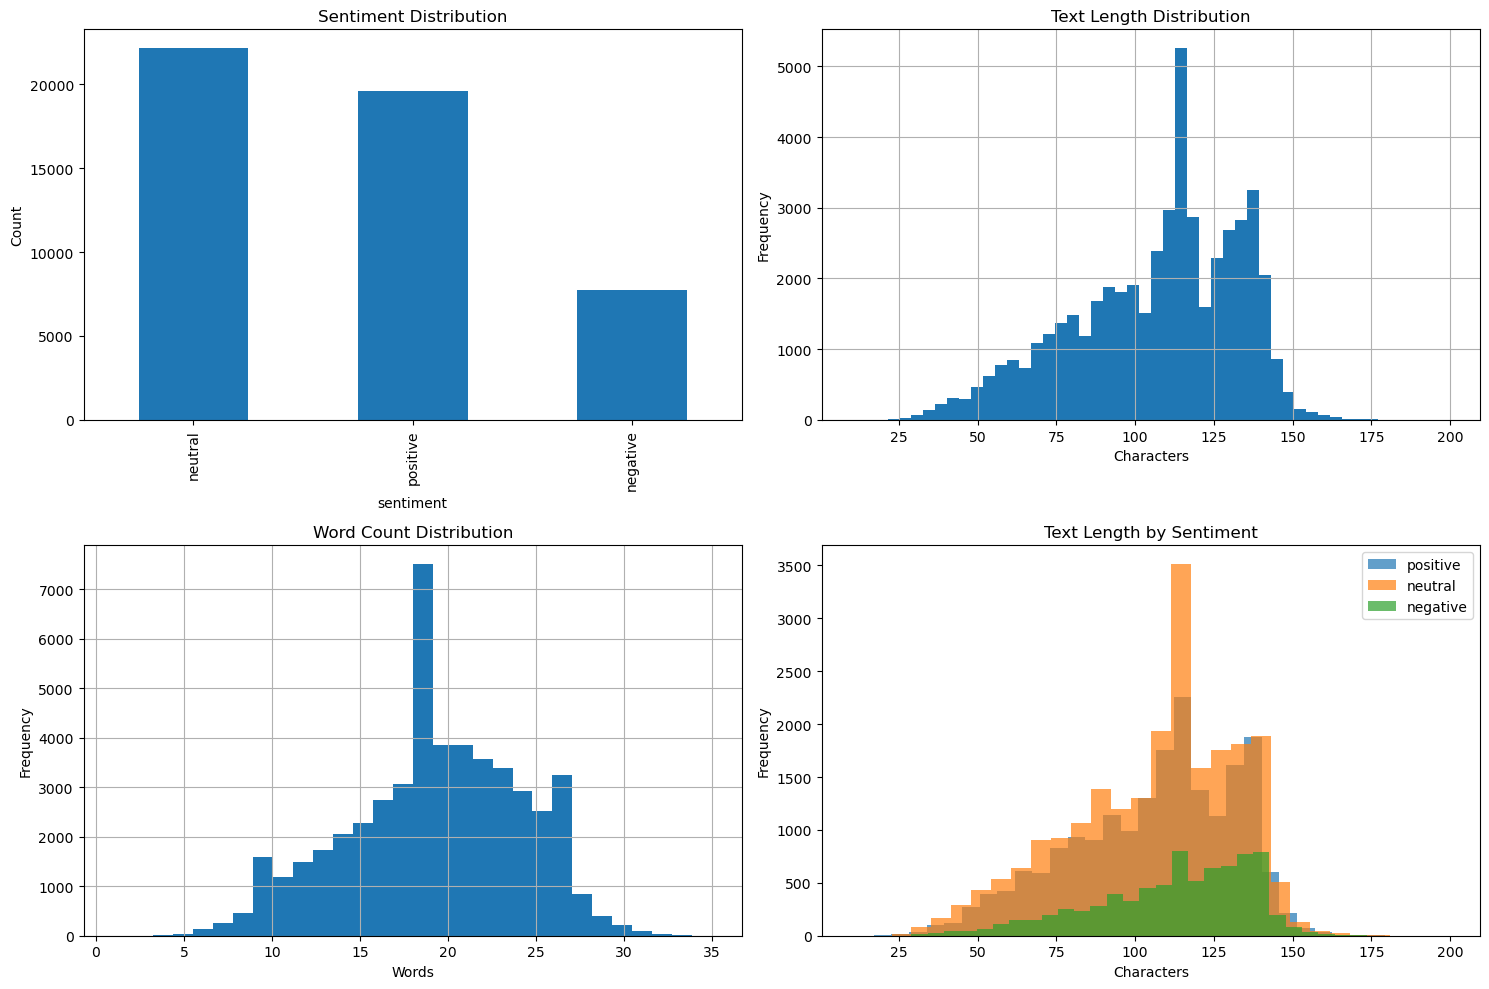

In [9]:
# Analyze text lengths
cleaned_df['text_length'] = cleaned_df['text'].str.len()
cleaned_df['word_count'] = cleaned_df['text'].str.split().str.len()

print("Text length statistics:")
print(cleaned_df[['text_length', 'word_count']].describe())

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sentiment distribution
cleaned_df['sentiment'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Sentiment Distribution')
axes[0,0].set_ylabel('Count')

# Text length distribution
cleaned_df['text_length'].hist(bins=50, ax=axes[0,1])
axes[0,1].set_title('Text Length Distribution')
axes[0,1].set_xlabel('Characters')
axes[0,1].set_ylabel('Frequency')

# Word count distribution
cleaned_df['word_count'].hist(bins=30, ax=axes[1,0])
axes[1,0].set_title('Word Count Distribution')
axes[1,0].set_xlabel('Words')
axes[1,0].set_ylabel('Frequency')

# Text length by sentiment
for sentiment in cleaned_df['sentiment'].unique():
    subset = cleaned_df[cleaned_df['sentiment'] == sentiment]
    axes[1,1].hist(subset['text_length'], alpha=0.7, label=sentiment, bins=30)
axes[1,1].set_title('Text Length by Sentiment')
axes[1,1].set_xlabel('Characters')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## Save Processed Dataset

In [10]:
# Prepare final dataset for BERT training
final_df = cleaned_df[['tweet_id', 'sentiment', 'text', 'source_file']].copy()

# Save as CSV
output_file = output_path / 'cleaned_twitter_data.csv'
final_df.to_csv(output_file, index=False)
print(f"Saved cleaned dataset to: {output_file}")

# Save train/validation split (80/20)
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    final_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=final_df['sentiment']
)

train_file = output_path / 'train.csv'
val_file = output_path / 'validation.csv'

train_df.to_csv(train_file, index=False)
val_df.to_csv(val_file, index=False)

print(f"\nSaved training set ({len(train_df)} samples) to: {train_file}")
print(f"Saved validation set ({len(val_df)} samples) to: {val_file}")

# Save BERT-ready format (text and labels only)
bert_train = train_df[['text', 'sentiment']]
bert_val = val_df[['text', 'sentiment']]

bert_train_file = output_path / 'bert_train.csv'
bert_val_file = output_path / 'bert_validation.csv'

bert_train.to_csv(bert_train_file, index=False)
bert_val.to_csv(bert_val_file, index=False)

print(f"\nSaved BERT training format to: {bert_train_file}")
print(f"Saved BERT validation format to: {bert_val_file}")

Saved cleaned dataset to: ../dataset/processed/cleaned_twitter_data.csv

Saved training set (39620 samples) to: ../dataset/processed/train.csv
Saved validation set (9906 samples) to: ../dataset/processed/validation.csv

Saved BERT training format to: ../dataset/processed/bert_train.csv
Saved BERT validation format to: ../dataset/processed/bert_validation.csv


## Summary Statistics

In [11]:
print("=" * 50)
print("DATA PREPROCESSING SUMMARY")
print("=" * 50)
print(f"Original tweets: {len(combined_df):,}")
print(f"After cleaning: {len(final_df):,}")
print(f"Reduction: {len(combined_df) - len(final_df):,} tweets ({((len(combined_df) - len(final_df)) / len(combined_df) * 100):.1f}%)")

print("\nFinal sentiment distribution:")
sentiment_counts = final_df['sentiment'].value_counts()
for sentiment, count in sentiment_counts.items():
    percentage = (count / len(final_df)) * 100
    print(f"  {sentiment}: {count:,} ({percentage:.1f}%)")

print(f"\nTrain set: {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")

print("\nFiles created:")
for file_path in [output_file, train_file, val_file, bert_train_file, bert_val_file]:
    if file_path.exists():
        print(f"  ✓ {file_path}")
    else:
        print(f"  ✗ {file_path}")

print("\n" + "=" * 50)
print("Preprocessing completed successfully!")
print("=" * 50)

DATA PREPROCESSING SUMMARY
Original tweets: 50,334
After cleaning: 49,526
Reduction: 808 tweets (1.6%)

Final sentiment distribution:
  neutral: 22,171 (44.8%)
  positive: 19,628 (39.6%)
  negative: 7,727 (15.6%)

Train set: 39,620 samples
Validation set: 9,906 samples

Files created:
  ✓ ../dataset/processed/cleaned_twitter_data.csv
  ✓ ../dataset/processed/train.csv
  ✓ ../dataset/processed/validation.csv
  ✓ ../dataset/processed/bert_train.csv
  ✓ ../dataset/processed/bert_validation.csv

Preprocessing completed successfully!
